<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering-and-Model-evaluation-+-validation" data-toc-modified-id="Feature-Engineering-and-Model-evaluation-+-validation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Engineering and Model evaluation + validation</a></span></li></ul></div>

# Feature Engineering and Model evaluation + validation

Let's work on the dataset we've been using during the model evaluation and evaluation notebook

In [1]:
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from copy import copy
from collections import Counter
from dataset import Dataset as dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss
from math import log2
from scipy import stats
from scipy.stats import kruskal
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm_notebook
from typing import List


# This line is important if you want your results to be reproducible
np.random.seed(555)

/Users/renero/miniconda3/envs/ie/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def do_discretize(df):
    df.discretize('x0', [(15, 20), (20, 25), (25, 30),
                         (30, 35), (35, 40), (40, 50)])
    df.discretize('x3', [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10, 20)])
    return df
    
def do_onehot(df):
    df.onehot_encode(df.names('features'))
    return df

def init_dataset(onehot=True, discretize=True):
    URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data'
    df = dataset(URL, header=None)
    df.to_int()
    #df.drop_na()
    df.set_target('x9')

    # Binomize and categorical
    df.drop_samples(df.samples_matching(3))
    df = df.to_categorical(['x1', 'x2', 'x4', 'x5', 'x6', 'x7', 'x8'])
    
    if discretize is True:
        do_discretize(df)

    if onehot is True:
        do_onehot(df)

    return df

In [3]:
def evaluate(X_train, y_train, X_test, y_test):
    my_model = LogisticRegression().fit(X_train, y_train)
    y_hat = my_model.predict(X_test)
    F1 = f1_score(y_test, y_hat)
    return F1


def evaluate_cv(X_train, y_train):
    my_model = LogisticRegression()
    cv_scores = cross_val_score(
        my_model, X_train, y_train, scoring='f1', cv=20)
    med = np.median(cv_scores)
    std = np.std(cv_scores)

    return med, cv_scores, std

In [4]:
def assess(df):
    X, y = df.split()
    baseline_F1, F1_scores, F1_std = evaluate_cv(X.train, y.train)
    test_F1 = evaluate(X.train, y.train, X.test, y.test)
    print('CV Training F1: {:.4f}'.format(baseline_F1))
    print('Test F1: {:.4f}'.format(test_F1))
    return baseline_F1, test_F1

In [5]:
df = init_dataset()
print('Baseline\n--------')
baseline_F1, test_F1 = assess(df)

Baseline
--------
CV Training F1: 0.8235
Test F1: 0.7778


In [6]:
top_features = df.features_importance(num_features=17)

In [7]:
df_filtered = df.keep_columns(list(top_features.keys()))
filtered_F1, filtered_test_F1 = assess(df_filtered);

CV Training F1: 0.8000
Test F1: 0.7782


In [8]:
df_raw = init_dataset(onehot=False, discretize=False)

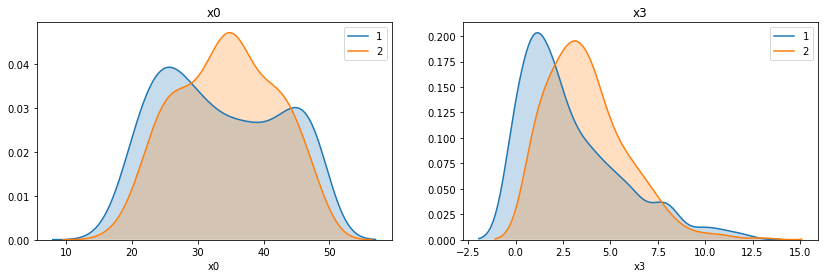

In [9]:
plt.figure(figsize=(14, 4))
num_plots = len(list(df_raw.numerical))
for index, feature in enumerate(list(df_raw.numerical)):
    plt.subplot(1, num_plots, index+1)
    df_raw.plot_double_density(feature)
    plt.legend(loc='best'); plt.ylabel('');
    plt.title(feature)
plt.show();

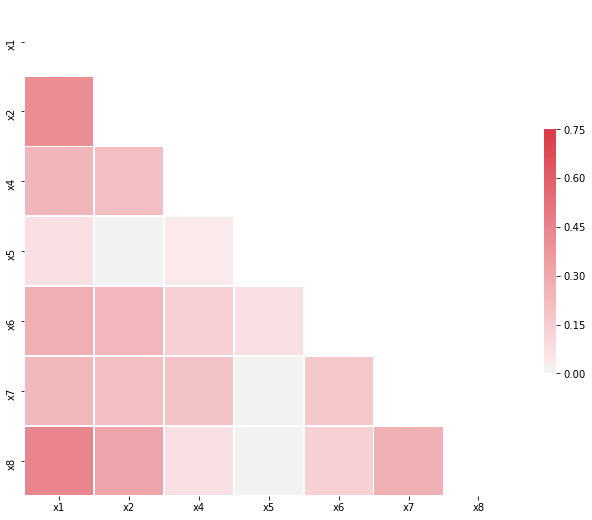

In [10]:
df_raw.plot_correlation_matrix(df_raw.categorical_correlated()[1])

In [11]:
df_raw.categorical_correlated()

([],           x1        x2        x4        x5        x6        x7        x8
 x1  1.000000  0.405233  0.242108  0.074349  0.269710  0.232866  0.442541
 x2  0.405233  1.000000  0.209987  0.000000  0.236095  0.204619  0.306513
 x4  0.242108  0.209987  1.000000  0.030094  0.137996  0.188436  0.070825
 x5  0.074349  0.000000  0.030094  1.000000  0.072216  0.025709  0.000000
 x6  0.269710  0.236095  0.137996  0.072216  1.000000  0.175690  0.136971
 x7  0.232866  0.204619  0.188436  0.025709  0.175690  1.000000  0.268880
 x8  0.442541  0.306513  0.070825  0.000000  0.136971  0.268880  1.000000)

information gain

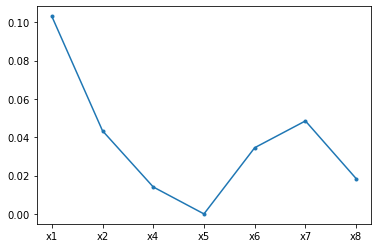

In [12]:
ig = [df_raw.IG(vble) for vble in df_raw.categorical_features]
plt.plot(range(len(df_raw.categorical_features)), ig, marker='.')
plt.xticks(range(len(df_raw.categorical_features)), df_raw.categorical_features)
plt.show()

In [13]:
df_raw = df_raw.drop_columns(['x4', 'x5'])
assess(do_onehot(do_discretize(copy(df_raw))))

CV Training F1: 0.8235
Test F1: 0.7749


(0.8235294117647058, 0.7749077490774907)

gp learn

In [15]:
from gplearn.genetic import SymbolicTransformer

df_raw.drop_na()
X, y = df_raw.split()
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
gp = SymbolicTransformer(generations=50, population_size=900,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)
gp.fit(X.train.values, y.train.values)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
gp_features = gp.transform(df_raw.data.values)

In [ ]:
pd.isna(X.train).any()

In [17]:
df_raw.drop_na()

In [18]:
df_raw.nas()

['x3']

In [25]:
df = pd.DataFrame({'age': [5, 6, np.NaN],
                   'born': [pd.NaT, pd.Timestamp('1939-05-27'),
                            pd.Timestamp('1940-04-25')],
                   'name': ['Alfred', 'Batman', ''],
                   'toy': [None, 'Batmobile', 'Joker']})
ds = dataset.from_dataframe(df)
ds.set_target('toy')
ds.data

,age,born,name
0,5.0,NaT,Alfred
1,6.0,1939-05-27,Batman
2,NaN,1940-04-25,


In [27]:
ds.target

0         None
1    Batmobile
2        Joker
Name: toy, dtype: object

In [28]:
ds.data.dropna(inplace=True)

In [29]:
ds.data

,age,born,name
1,6.0,1939-05-27,Batman


In [32]:
ds.target = ds.target[ds.target.index.isin(ds.data.index)]

ds.target = ds.target.reset_index(drop=True)

In [39]:
ds.target

0    Batmobile
Name: toy, dtype: object

In [41]:
ds.features = ds.features.reset_index(drop=True)
ds.features

,age,born,name
0,6.0,1939-05-27,Batman


In [42]:
ds.features.shape

(1, 3)